### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [1]:
!pip install folium


[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

np.random.seed(0)

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [4]:
df_train = pd.read_csv('train_second_task.csv')
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [5]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df_train.drop(columns='dropoff_datetime',inplace=True)
df_train.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [6]:
df_train['pickup_datetime'] = pd.to_datetime(df_train['pickup_datetime'])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   passenger_count     1458644 non-null  int64         
 4   pickup_longitude    1458644 non-null  float64       
 5   pickup_latitude     1458644 non-null  float64       
 6   dropoff_longitude   1458644 non-null  float64       
 7   dropoff_latitude    1458644 non-null  float64       
 8   store_and_fwd_flag  1458644 non-null  object        
 9   trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(2)
memory usage: 111.3+ MB


В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

(array([1.45864e+06, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        2.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([1.0000000e+00, 3.5262910e+05, 7.0525720e+05, 1.0578853e+06,
        1.4105134e+06, 1.7631415e+06, 2.1157696e+06, 2.4683977e+06,
        2.8210258e+06, 3.1736539e+06, 3.5262820e+06]),
 <BarContainer object of 10 artists>)

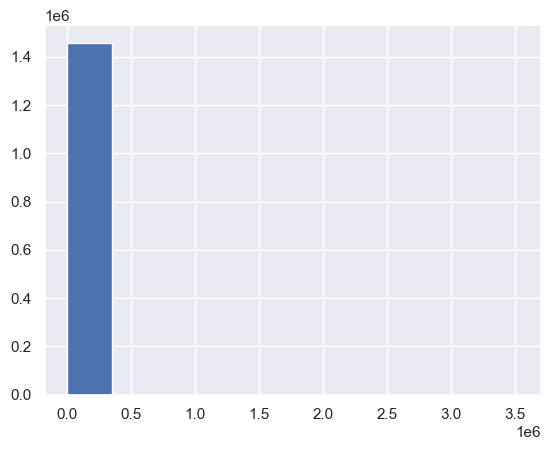

In [7]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
plt.hist(x = df_train['trip_duration'])

(array([3.30000e+01, 1.77000e+02, 3.18000e+02, 6.01000e+02, 4.10000e+02,
        6.27000e+02, 4.78000e+02, 7.27000e+02, 9.26000e+02, 1.09600e+03,
        1.38500e+03, 2.34600e+03, 4.54100e+03, 1.02530e+04, 2.17410e+04,
        4.54460e+04, 8.05240e+04, 1.27788e+05, 1.75930e+05, 2.14182e+05,
        2.25253e+05, 2.05072e+05, 1.55983e+05, 9.72090e+04, 4.95850e+04,
        2.28680e+04, 8.62500e+03, 2.06600e+03, 2.88000e+02, 5.80000e+01,
        3.10000e+01, 9.00000e+00, 2.30000e+01, 3.20000e+01, 2.80000e+01,
        3.50000e+01, 2.24000e+02, 1.72200e+03, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 2.00000e+00, 1.00000e+00]),
 array([ 0.69314718,  0.98079933,  1.26845149,  1.55610364,  1.8437558 ,
         2.13140795,  2.41906011,  2.70671226,  2.99436442,  3.28201657,
         3.56966872,  3.85732088,  4.14497303,  4.43262519,  4.72027734,
         5.0079295 ,  5.29558165,  5.58323381,  5

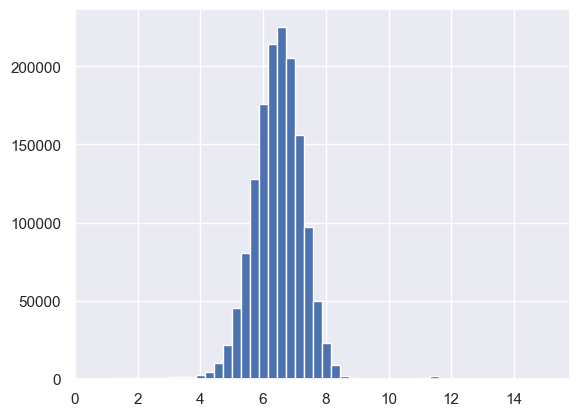

In [8]:
plt.hist(np.log1p(df_train['trip_duration'].values), bins=50)

{'whiskers': [<matplotlib.lines.Line2D at 0x238ae032a70>,
 'caps': [<matplotlib.lines.Line2D at 0x238ae033070>,
 'boxes': [<matplotlib.lines.Line2D at 0x238ae032770>],
 'medians': [<matplotlib.lines.Line2D at 0x238ae033670>],
 'fliers': [<matplotlib.lines.Line2D at 0x238ae033940>],
 'means': []}

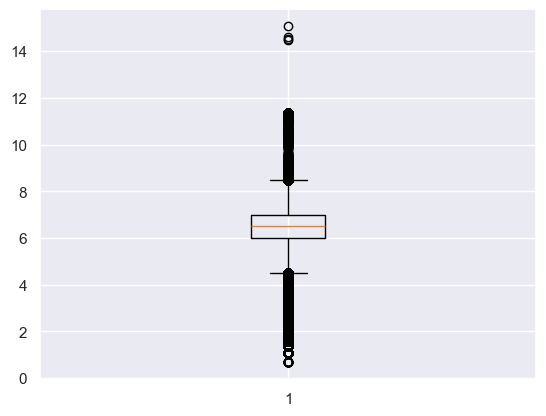

In [9]:
plt.boxplot(np.log1p(df_train['trip_duration'].values))

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

In [10]:
df_train['trip_duration'].describe()

count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

Ответ от меня: Почти все поездки укладываются в один диапозон, но есть огромные выбросы 

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

Ответ от меня: целевая метрика скошена + на временной целевой переменной это метрика лучше + учитывается масштаб ошибки

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

In [11]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df_train['log_trip_duration'] = df_train['trip_duration'].apply(np.log1p)

<Axes: >

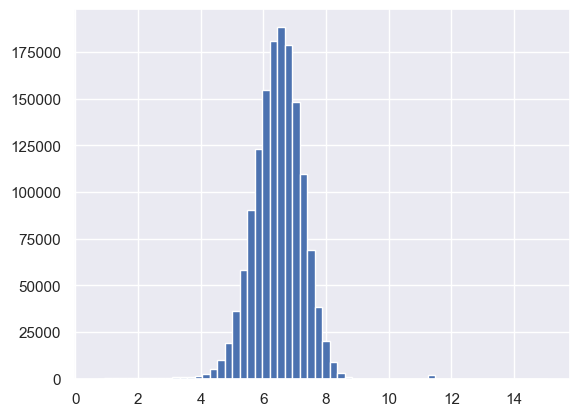

In [12]:
df_train['log_trip_duration'].hist(bins=60)

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [13]:
df_train['mean_log_trip_duration'] = df_train['log_trip_duration'].mean()
def rmsle(log1p_y_true, log1p_y_pred): 
    #╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    new_series = (log1p_y_true - log1p_y_pred)**2
    return np.sqrt(new_series.mean())

rmsle_best_const = rmsle(df_train['log_trip_duration'], df_train['mean_log_trip_duration'] ) 
print(rmsle_best_const)
assert np.allclose(rmsle_best_const, 0.79575, 1e-4)

0.7957592365411509


## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

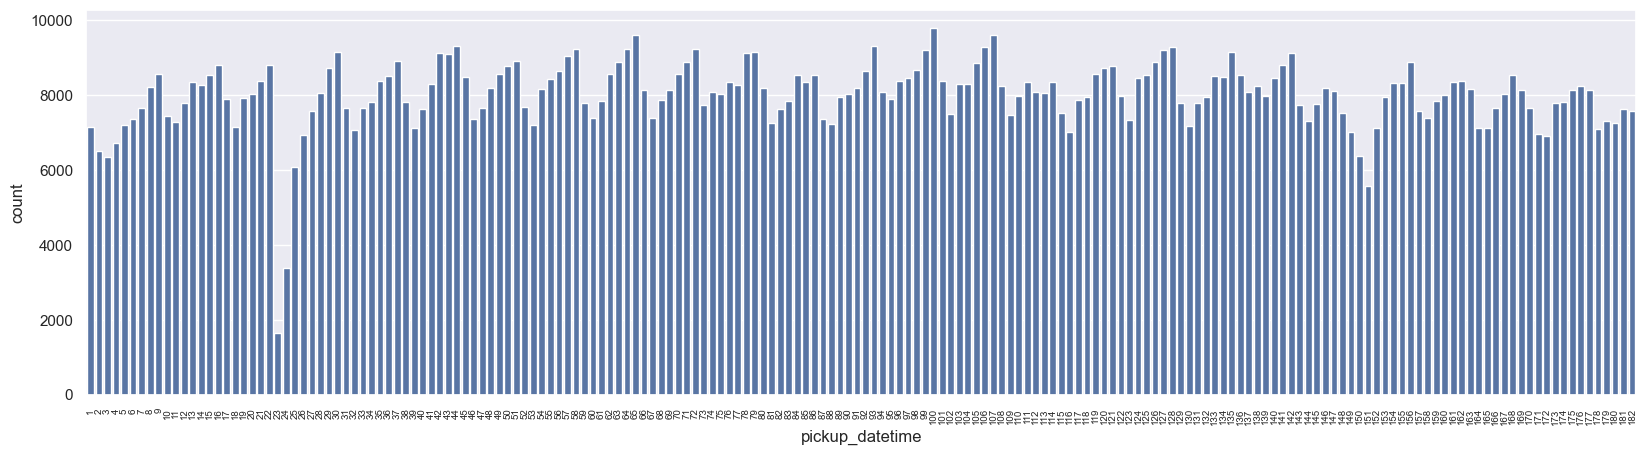

In [14]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
plt.figure(figsize=(20, 5))  
plt.xticks(rotation=90, fontsize=7)
sns.countplot(x=df_train['pickup_datetime'].dt.day_of_year)
plt.show()

In [15]:
df_train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration',
       'log_trip_duration', 'mean_log_trip_duration'],
      dtype='object')

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

In [16]:
df_for_research = df_train.copy()
df_for_research['pickup_datetime'] = df_for_research['pickup_datetime'].dt.day_of_year
df_for_research = df_for_research.groupby('pickup_datetime')['trip_duration'].count().reset_index().rename(columns={'trip_duration' : 'trip_counter'})
df_for_research.sort_values('trip_counter')

,pickup_datetime,trip_counter
22,23,1648
23,24,3383
150,151,5570
24,25,6084
2,3,6353
...,...,...
43,44,9309
92,93,9325
64,65,9597
106,107,9602


In [17]:
print(df_train['pickup_datetime'].dt.day_of_year.max(), df_train['pickup_datetime'].dt.year.max())

182 2016


Ответ: 23 Января 2016 года официальные лица Нью-Йорка рассматривают возможность запрета на поездки, поскольку снег выпадает быстрее, чем ожидалось.

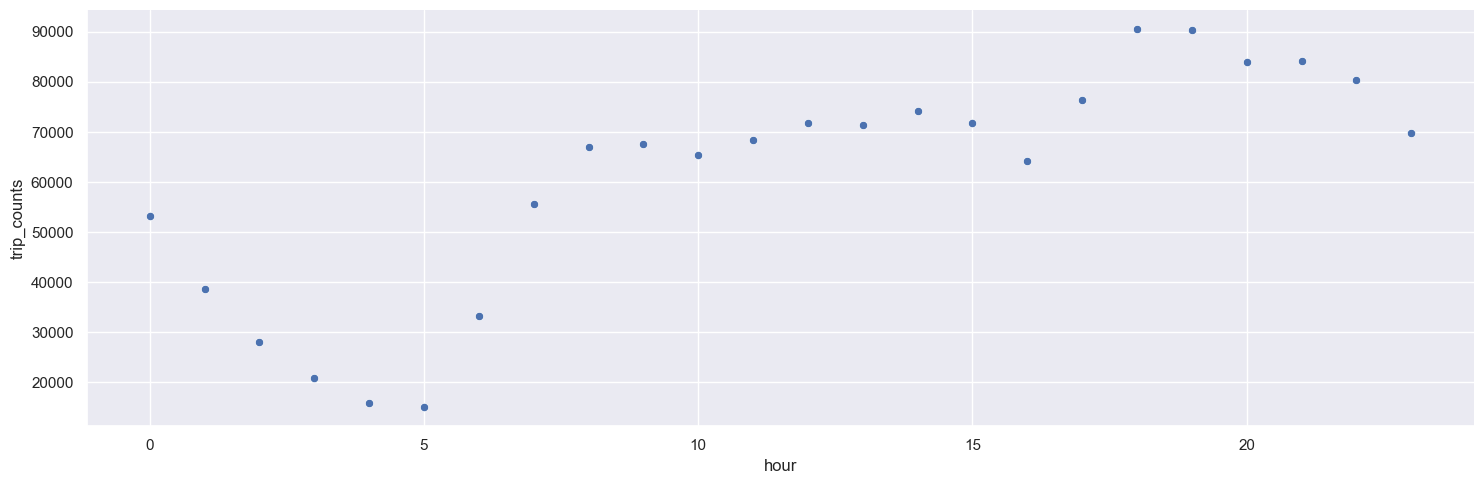

In [18]:
#Теперь нарисуем relplot зависимостей 
df_train['day_of_week'] = df_train['pickup_datetime'].dt.day_of_week
df_train['hour'] = df_train['pickup_datetime'].dt.hour
sns.relplot(
    data = df_train.groupby('hour')['pickup_datetime'].count().reset_index().rename(columns={'pickup_datetime':'trip_counts'}), 
    x ='hour', 
    y ='trip_counts',
    aspect= 3)


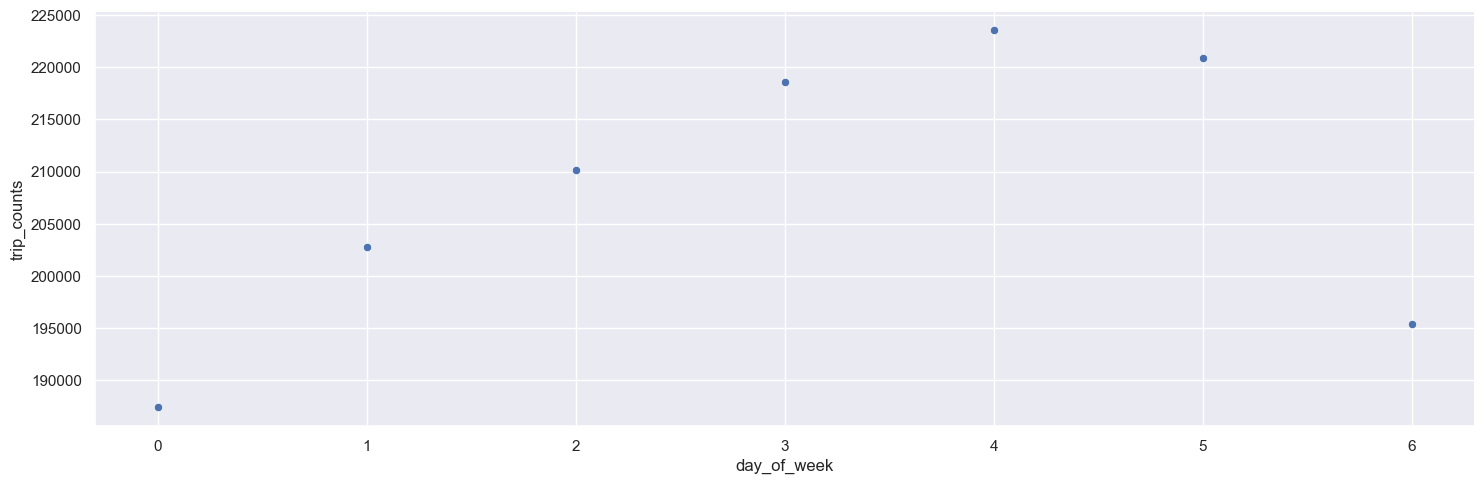

In [19]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
sns.relplot(
    data = df_train.groupby('day_of_week')['pickup_datetime'].count().reset_index().rename(columns={'pickup_datetime':'trip_counts'}), 
    x ='day_of_week', 
    y ='trip_counts',
    aspect= 3)


**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

In [20]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
import plotly.express as px
df_train['month'] = df_train['pickup_datetime'].dt.month
fig = px.scatter(
    data_frame=df_train.groupby(['hour','month'])['pickup_datetime'].count().reset_index().rename(columns={'pickup_datetime':'trip_counts'}),
    x='hour',
    y='trip_counts',
    color='month'
)
fig.show()

In [21]:
fig = px.scatter(
    data_frame=df_train.groupby(['hour','day_of_week'])['pickup_datetime'].count().reset_index().rename(columns={'pickup_datetime':'trip_counts'}),
    x='hour',
    y='trip_counts',
    color='day_of_week'
)
fig.show()

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3 (используйте `train_test_split` из `sklearn`). По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [22]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df_train.drop(columns=['mean_log_trip_duration', 'day_of_week', 'hour', 'month', 'trip_duration'], inplace=True)
df_train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'log_trip_duration'],
      dtype='object')

In [23]:
from sklearn.model_selection import train_test_split
df_train['day_of_week'] = df_train['pickup_datetime'].dt.strftime('%a')
df_train['month'] = df_train['pickup_datetime'].dt.month
df_train['hour'] = df_train['pickup_datetime'].dt.hour
df_train['day_of_year'] = df_train['pickup_datetime'].dt.day_of_year
df_train['abnormal_date'] = df_train['day_of_year'].isin([23,24]) 
y = df_train['log_trip_duration']
X = df_train.drop(columns=['log_trip_duration', 'id', 'pickup_datetime','vendor_id'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=52)

In [24]:
#ну так на всякий
df_train.groupby('vendor_id')['log_trip_duration'].median()

vendor_id
1    6.490724
2    6.502790
Name: log_trip_duration, dtype: float64

In [25]:
X_train.head()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,day_of_week,month,hour,day_of_year,abnormal_date
1081838,6,-73.996872,40.723789,-73.988831,40.758530,N,Tue,5,15,131,False
680565,2,-73.996422,40.747742,-73.984505,40.779610,N,Tue,6,22,180,False
416249,1,-73.995743,40.769459,-73.981056,40.763859,N,Fri,3,14,64,False
1145204,1,-74.000984,40.747162,-73.993690,40.743179,N,Fri,4,0,120,False
179663,1,-73.983681,40.694683,-73.981804,40.764381,N,Sat,3,19,65,False


In [26]:
train_for_visual = pd.concat([X_train, y_train], axis=1)
train_for_visual.head()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,day_of_week,month,hour,day_of_year,abnormal_date,log_trip_duration
1081838,6,-73.996872,40.723789,-73.988831,40.758530,N,Tue,5,15,131,False,7.296413
680565,2,-73.996422,40.747742,-73.984505,40.779610,N,Tue,6,22,180,False,6.520621
416249,1,-73.995743,40.769459,-73.981056,40.763859,N,Fri,3,14,64,False,6.790097
1145204,1,-74.000984,40.747162,-73.993690,40.743179,N,Fri,4,0,120,False,4.691348
179663,1,-73.983681,40.694683,-73.981804,40.764381,N,Sat,3,19,65,False,7.226936


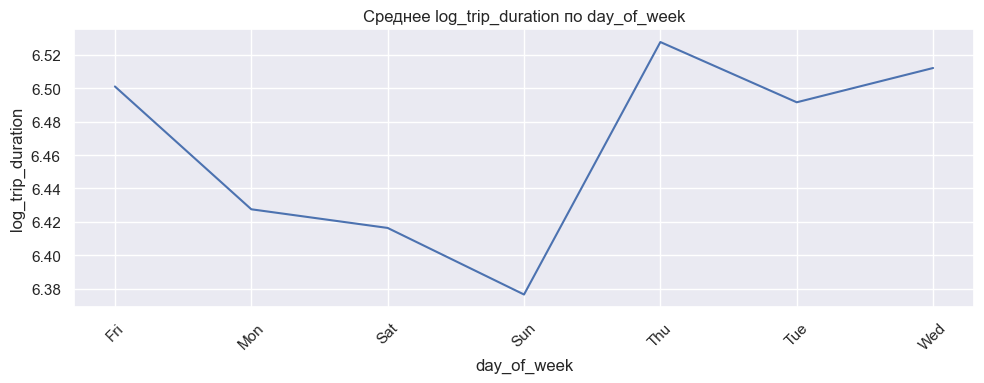

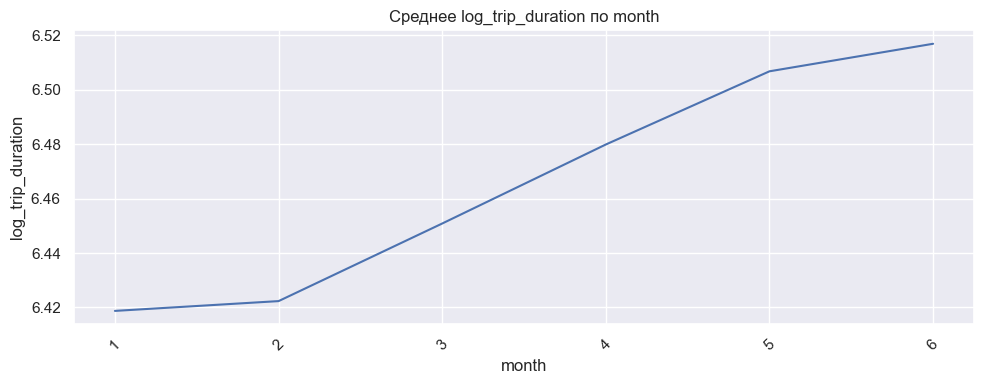

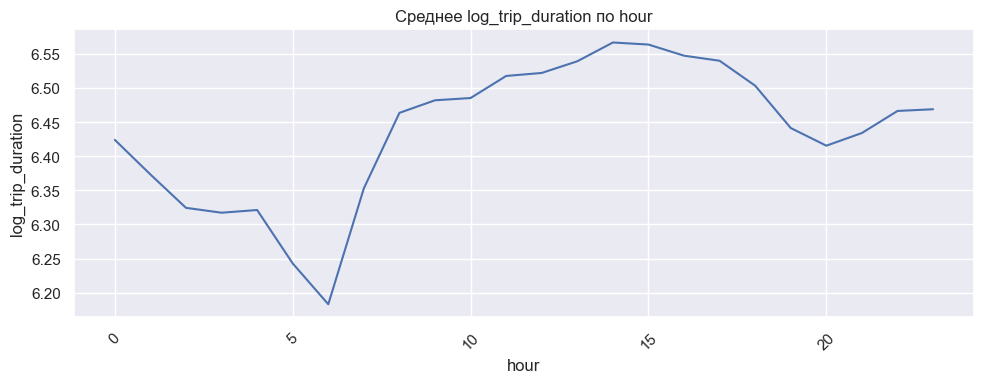

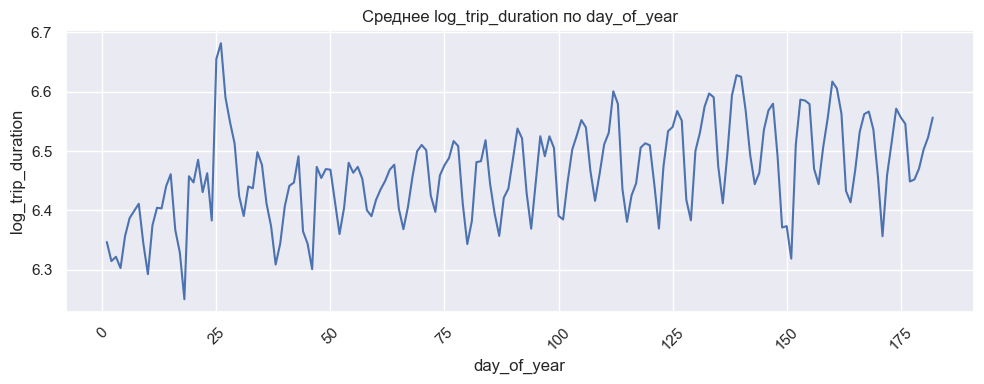

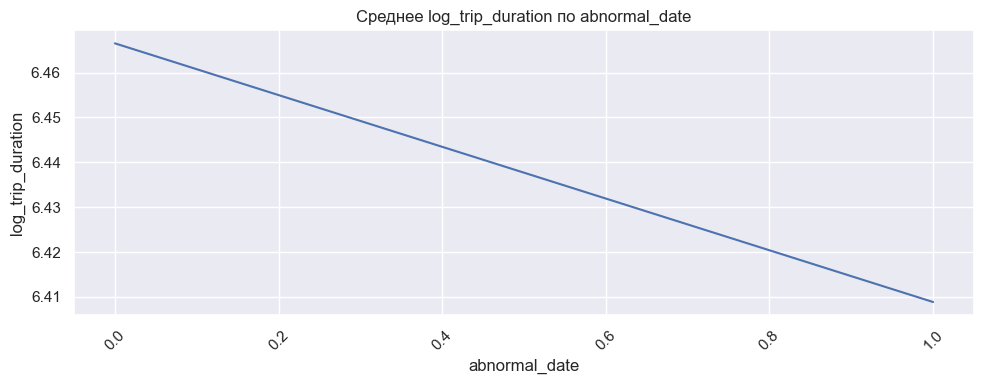

In [27]:
group_cols = ['day_of_week', 'month', 'hour', 'day_of_year', 'abnormal_date']

for col in group_cols:
    avg = train_for_visual.groupby(col)['log_trip_duration'].mean().reset_index()

    plt.figure(figsize=(10, 4))
    sns.lineplot(data=avg, x=col, y='log_trip_duration')
    plt.title(f'Среднее log_trip_duration по {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

Ответ от меня:
1. Да 
2. Падает, вероятно потому что самих поездок было меньше и вряд ли в снегопад кто-то планировал далеко выбираться
3. Недельная сезонность с положительным трендом 

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [28]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
#Добавил их выше 

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков _стоит рассматривать в этой задаче_   как категориальные, а какие - как численные? Почему?

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [29]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)
keep_col = list(X_train.dtypes[X_train.dtypes == "bool"].index)
numeric_features = list(X_train.dtypes[X_train.dtypes == np.number].index)
X_train['abnormal_date'] = X_train['abnormal_date'].astype('int64')
X_test['abnormal_date'] = X_test['abnormal_date'].astype('int64')


column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features),
    ('keep_col', 'passthrough', keep_col)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])


In [30]:
model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

print("Test RMSE = %.4f" % root_mean_squared_error(y_test, y_pred))
print("Test RMSE = %.4f" % root_mean_squared_error(y_train, y_train_pred))

Test RMSE = 0.7817
Test RMSE = 0.7765


## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [31]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [32]:
show_circles_on_map(df_train.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [33]:
show_circles_on_map(df_train.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие пункты (или скопления точек, в количестве 2-3), по вашему мнению, выделяются на карте от основной массы и могут быть полезны для нашей задачи? Почему вы их выбрали? В чём особенность этих скоплений точек для нашей задачи?

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [34]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
def haversine(latitude_first, longitude_first, latitude_second, longitude_second):
    R = 6371  # радиус Земли в км
    latitude_first, longitude_first, latitude_second, longitude_second = map(
                                                                 np.radians, 
                                                                 [latitude_first, 
                                                                  longitude_first, 
                                                                  latitude_second, 
                                                                  longitude_second]
                                                                )
    
    dlat = latitude_second - latitude_first
    dlon = longitude_second - longitude_first

    a = np.sin(dlat/2)**2 + np.cos(latitude_first) * np.cos(latitude_second) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c

In [35]:
df_train['haversine'] = haversine(
                                 df_train['pickup_latitude'],
                                 df_train['pickup_longitude'],
                                 df_train['dropoff_latitude'],
                                 df_train['dropoff_longitude']
                                )
df_train.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,day_of_week,month,hour,day_of_year,abnormal_date,haversine
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,6.122493,Mon,3,17,74,False,1.498521
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,6.498282,Sun,6,0,164,False,1.805507
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,7.661527,Tue,1,11,19,False,6.385098
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,6.063785,Wed,4,19,97,False,1.485498
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,6.077642,Sat,3,13,86,False,1.188588


Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку `log_haversine`:

In [36]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df_train['log_haversine'] = np.log(df_train['haversine'] + 1e-4)

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [37]:
your_df = df_train 
assert your_df['log_haversine'].corr(your_df['log_trip_duration']) > your_df['haversine'].corr(your_df['log_trip_duration'])

**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

In [38]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df_train['trip_duration'] = df_train['log_trip_duration'].apply(lambda x: np.exp(x) - 1)

<Axes: >

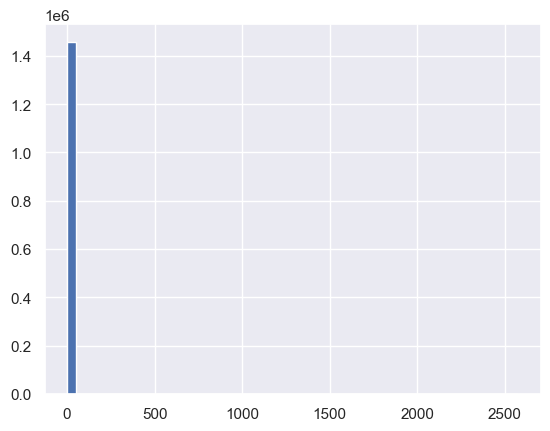

In [39]:
df_train['avg_speed'] = df_train['haversine'] * 1000 / df_train['trip_duration']
df_train['avg_speed'].hist(bins=50)
#Будем считать в метрах в секунду, а то совсем не камельфо в км/с

(array([1.01420e+04, 1.71700e+03, 1.24900e+03, 1.24400e+03, 1.58000e+03,
        2.12500e+03, 3.29400e+03, 5.27600e+03, 8.50900e+03, 1.34610e+04,
        2.05190e+04, 3.02990e+04, 4.17350e+04, 5.63000e+04, 7.22650e+04,
        8.79780e+04, 1.02652e+05, 1.13631e+05, 1.19453e+05, 1.18413e+05,
        1.12938e+05, 1.02711e+05, 9.01840e+04, 7.62740e+04, 6.36820e+04,
        5.09250e+04, 4.02040e+04, 3.10930e+04, 2.36410e+04, 1.78530e+04,
        1.32520e+04, 9.73100e+03, 6.53700e+03, 3.87800e+03, 1.98900e+03,
        9.61000e+02, 4.08000e+02, 1.67000e+02, 8.10000e+01, 5.50000e+01,
        2.90000e+01, 2.30000e+01, 1.80000e+01, 2.00000e+01, 1.20000e+01,
        1.20000e+01, 1.50000e+01, 1.30000e+01, 8.00000e+00, 1.00000e+01,
        8.00000e+00, 5.00000e+00, 3.00000e+00, 9.00000e+00, 4.00000e+00,
        7.00000e+00, 0.00000e+00, 5.00000e+00, 2.00000e+00, 1.00000e+00,
        1.00000e+00, 1.00000e+00, 2.00000e+00, 1.00000e+00, 4.00000e+00,
        1.00000e+00, 1.00000e+00, 0.00000e+00, 2.00

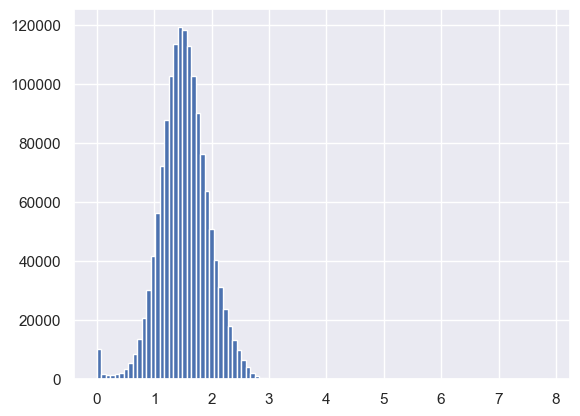

In [40]:
plt.hist(np.log1p(df_train['avg_speed'].values), bins = 100)

In [41]:
df_train['avg_speed'].describe()

count    1.458644e+06
mean     4.006447e+00
std      4.160423e+00
min      0.000000e+00
25%      2.533687e+00
50%      3.553327e+00
75%      4.956920e+00
max      2.576344e+03
Name: avg_speed, dtype: float64

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

<Axes: >

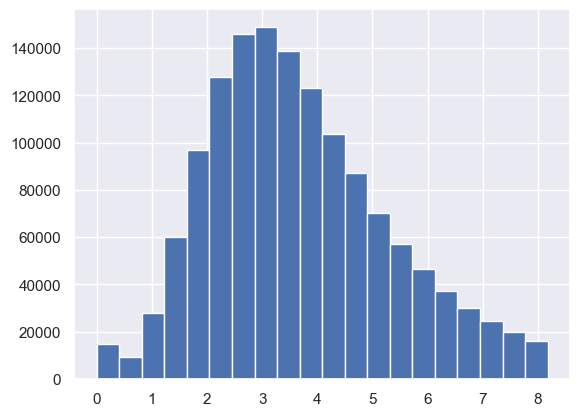

In [42]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df_train[df_train['avg_speed'] < df_train['avg_speed'].quantile(0.95)]['avg_speed'].hist(bins=20)

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

<Axes: xlabel='hour', ylabel='day_of_week'>

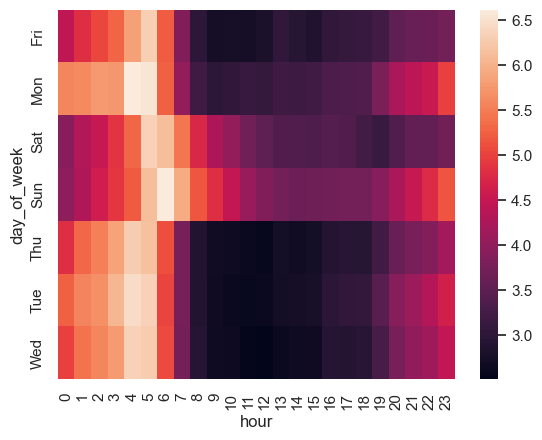

In [43]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
sns.heatmap(data = df_train.groupby(['day_of_week', 'hour'])['avg_speed'].median().unstack(),
            fmt = '1.f'
           )

In [44]:
df_train.drop(columns='avg_speed', inplace=True)
'avg_speed' in set(df_train.columns)

False

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
Ответ: подглядываем в целевую переменную, переносим знание о ней в обучающую выборку

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [45]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df_train['pickup_with_free_roads'] = df_train['day_of_week'].isin(['Mon', 'Fri', 'Thu', 'Tue', 'Wed']) \
                                     & \
                                     df_train['hour'].isin(list(range(8,19))).astype('int64')
df_train['abnormal_date'] = df_train['abnormal_date'].astype('int64')
df_train.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,day_of_week,month,hour,day_of_year,abnormal_date,haversine,log_haversine,trip_duration,pickup_with_free_roads
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,6.122493,Mon,3,17,74,0,1.498521,0.404545,455.0,True
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,6.498282,Sun,6,0,164,0,1.805507,0.590897,663.0,False
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,7.661527,Tue,1,11,19,0,6.385098,1.853983,2124.0,True
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,6.063785,Wed,4,19,97,0,1.485498,0.395818,429.0,False
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,6.077642,Sat,3,13,86,0,1.188588,0.172851,435.0,False


## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [46]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df_train[['passenger_count', 'vendor_id', 'store_and_fwd_flag']].describe()

,passenger_count,vendor_id
count,1.458644e+06,1.458644e+06
mean,1.664530e+00,1.534950e+00
std,1.314242e+00,4.987772e-01
min,0.000000e+00,1.000000e+00
25%,1.000000e+00,1.000000e+00
50%,1.000000e+00,2.000000e+00
75%,2.000000e+00,2.000000e+00
max,9.000000e+00,2.000000e+00


In [47]:
cols = ['passenger_count', 'vendor_id', 'store_and_fwd_flag']
for col in cols:
    print('Уникальных значений у', col, ':', df_train[col].nunique())

Уникальных значений у passenger_count : 10
Уникальных значений у vendor_id : 2
Уникальных значений у store_and_fwd_flag : 2


Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

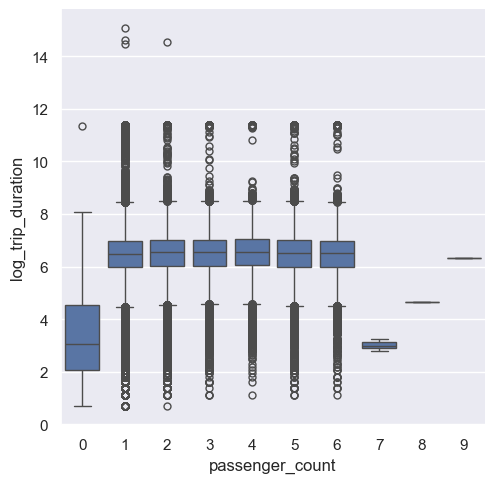

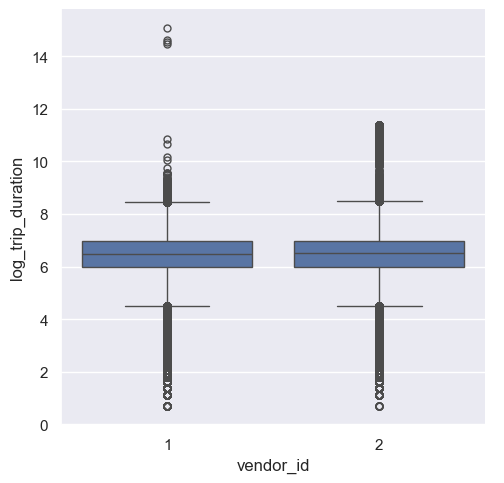

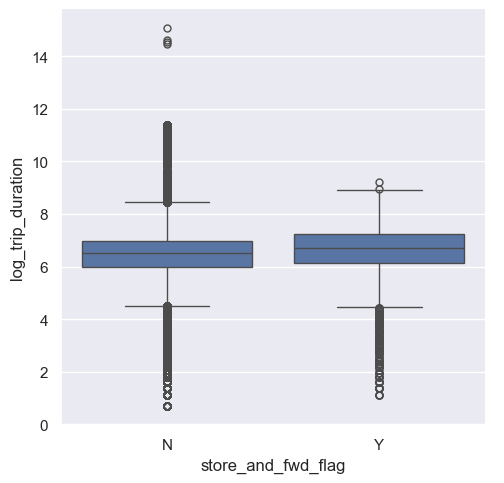

In [48]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
cols = ['passenger_count', 'vendor_id', 'store_and_fwd_flag']
for col in cols:
    sns.catplot(data = df_train,
                x = col,
                y = 'log_trip_duration',
                kind='box'
    )

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [49]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 19 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   id                      1458644 non-null  object        
 1   vendor_id               1458644 non-null  int64         
 2   pickup_datetime         1458644 non-null  datetime64[ns]
 3   passenger_count         1458644 non-null  int64         
 4   pickup_longitude        1458644 non-null  float64       
 5   pickup_latitude         1458644 non-null  float64       
 6   dropoff_longitude       1458644 non-null  float64       
 7   dropoff_latitude        1458644 non-null  float64       
 8   store_and_fwd_flag      1458644 non-null  object        
 9   log_trip_duration       1458644 non-null  float64       
 10  day_of_week             1458644 non-null  object        
 11  month                   1458644 non-null  int32         
 12  hour          

In [50]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df_train.replace({'vendor_id': {2 : 0}, 'store_and_fwd_flag': {'N': 0, 'Y': 1}}, inplace=True)
df_train[['vendor_id', 'store_and_fwd_flag']].describe()                 

C:\Users\Мотян\AppData\Local\Temp\ipykernel_18468\732956609.py:2: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



,vendor_id,store_and_fwd_flag
count,1.458644e+06,1.458644e+06
mean,4.650497e-01,5.515396e-03
std,4.987772e-01,7.406066e-02
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00
75%,1.000000e+00,0.000000e+00
max,1.000000e+00,1.000000e+00


In [51]:
df_train.groupby('vendor_id')[['log_trip_duration', 'log_haversine']].median()

,log_trip_duration,log_haversine
vendor_id,,
0,6.502790,0.742615
1,6.490724,0.734917


**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [52]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df_train.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,day_of_week,month,hour,day_of_year,abnormal_date,haversine,log_haversine,trip_duration,pickup_with_free_roads
0,id2875421,0,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,0,6.122493,Mon,3,17,74,0,1.498521,0.404545,455.0,True
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,0,6.498282,Sun,6,0,164,0,1.805507,0.590897,663.0,False
2,id3858529,0,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,0,7.661527,Tue,1,11,19,0,6.385098,1.853983,2124.0,True
3,id3504673,0,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,0,6.063785,Wed,4,19,97,0,1.485498,0.395818,429.0,False
4,id2181028,0,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,0,6.077642,Sat,3,13,86,0,1.188588,0.172851,435.0,False


In [53]:
df_train['pickup_with_free_roads'] = df_train['pickup_with_free_roads'].astype('int64') 
y = df_train['log_trip_duration']
X = df_train.drop(columns=['id', 'vendor_id', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 
                           'log_trip_duration', 'trip_duration', 'haversine']
                 )
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=52)

In [54]:
X

,passenger_count,store_and_fwd_flag,day_of_week,month,hour,day_of_year,abnormal_date,log_haversine,pickup_with_free_roads
0,1,0,Mon,3,17,74,0,0.404545,1
1,1,0,Sun,6,0,164,0,0.590897,0
2,1,0,Tue,1,11,19,0,1.853983,1
3,1,0,Wed,4,19,97,0,0.395818,0
4,1,0,Sat,3,13,86,0,0.172851,0
...,...,...,...,...,...,...,...,...,...
1458639,4,0,Fri,4,13,99,0,0.203088,1
1458640,1,0,Sun,1,7,10,0,1.800048,0
1458641,1,0,Fri,4,6,113,0,2.057286,0
1458642,1,0,Tue,1,15,5,0,0.088619,1


In [55]:
categorical = ['day_of_week']
numeric_features = ['passenger_count', 'day_of_year', 'log_haversine']
keep_col = ['store_and_fwd_flag', 'abnormal_date', 'pickup_with_free_roads']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features), 
    ('keep_col', 'passthrough', keep_col)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

In [56]:
model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

print("Test RMSE = %.4f" % root_mean_squared_error(y_test, y_pred))
print("Train RMSE = %.4f" % root_mean_squared_error(y_train, y_train_pred))

Test RMSE = 0.5592
Train RMSE = 0.5623


## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты (выбросы, или outliers): с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите __обучающую выборку__ от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

count    1.458644e+06
mean     7.633269e-01
std      1.141426e+00
min     -9.210340e+00
25%      2.085874e-01
50%      7.389888e-01
75%      1.354659e+00
max      7.123599e+00
Name: log_haversine, dtype: float64

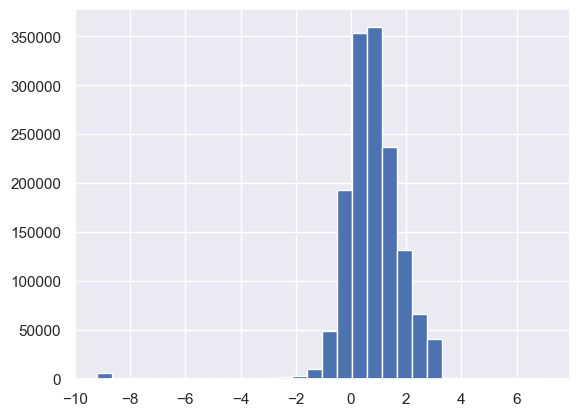

In [57]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df_train['log_haversine'].hist(bins=30)
df_train['log_haversine'].describe()

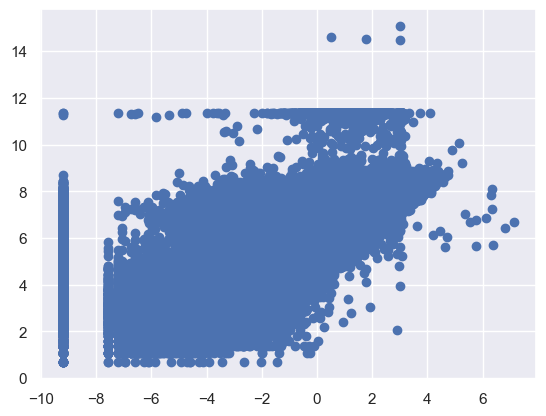

In [58]:
plt.scatter(data=df_train, x='log_haversine', y='log_trip_duration')

In [59]:
df_train = df_train[df_train['log_haversine'] > -8]

Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [60]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df_train['pickup_with_free_roads'] = df_train['pickup_with_free_roads'].astype('int64') 
y = df_train['log_trip_duration']
X = df_train.drop(columns=['id', 'vendor_id', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 
                           'log_trip_duration', 'trip_duration', 'haversine']
                 )
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=52)

C:\Users\Мотян\AppData\Local\Temp\ipykernel_18468\1805040772.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [61]:
from sklearn.linear_model import Lasso
categorical = ['day_of_week']
numeric_features = ['passenger_count', 'day_of_year', 'log_haversine']
keep_col = ['store_and_fwd_flag', 'abnormal_date', 'pickup_with_free_roads']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features), 
    ('keep_col', 'passthrough', keep_col)
])

pipeline_1 = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])

pipeline_2 = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

In [62]:
model_1 = pipeline_1.fit(X_train, y_train)
y_pred_1 = model_1.predict(X_test)
y_train_pred_1 = model_1.predict(X_train)

model_2 = pipeline_2.fit(X_train, y_train)
y_pred_2 = model_2.predict(X_test)
y_train_pred_2 = model_2.predict(X_train)

print("LASSO Test RMSE = %.4f" % root_mean_squared_error(y_test, y_pred_1))
print("LASSO Train RMSE = %.4f" % root_mean_squared_error(y_train, y_train_pred_1))

print("RIDGE Test RMSE = %.4f" % root_mean_squared_error(y_test, y_pred_2))
print("RIDGE Train RMSE = %.4f" % root_mean_squared_error(y_train, y_train_pred_2))

LASSO Test RMSE = 0.7863
LASSO Train RMSE = 0.7841
RIDGE Test RMSE = 0.4771
RIDGE Train RMSE = 0.4751


Разбейте _обучающую выборку_ на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [63]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
y = df_train['log_trip_duration']
X = df_train.drop(columns=['id', 'vendor_id', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 
                           'log_trip_duration', 'trip_duration', 'haversine']
                 )
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=52)

In [64]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
X_tr, X_ts, y_tr, y_ts = train_test_split(X_train, y_train, test_size=0.2, random_state=11, shuffle=True)

categorical = ['day_of_week']
numeric_features = ['passenger_count', 'day_of_year', 'log_haversine']
keep_col = ['store_and_fwd_flag', 'abnormal_date', 'pickup_with_free_roads']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features), 
    ('keep_col', 'passthrough', keep_col)
])

alphas =  np.logspace(-1, 1, 30)

def tune_model(ModelClass, model_name):
    best = {'alpha': None, 'rmse_val': np.inf, 'model': None}
    for a in alphas:
        pipeline = Pipeline(steps=[
                                ('ohe_and_scaling', column_transformer),
                                ('regression', ModelClass(alpha=a))
                            ])
        pipeline.fit(X_tr, y_tr)
        y_ts_pred = pipeline.predict(X_ts)
        rmse = root_mean_squared_error(y_ts, y_ts_pred)
        if rmse < best['rmse_val']:
            best.update({'alpha': a, 'rmse_val': rmse, 'model': pipeline})
    print(f"{model_name}: best alpha = {best['alpha']:.2e}, RMSE on val = {best['rmse_val']:.4f}")
    return best

best_ridge = tune_model(Ridge, "Ridge")
best_lasso = tune_model(Lasso, "Lasso")


Ridge: best alpha = 1.00e+01, RMSE on val = 0.4756
Lasso: best alpha = 1.00e-01, RMSE on val = 0.5076


In [65]:
final_ridge = best_ridge['model'].fit(X_train, y_train)
final_lasso = best_lasso['model'].fit(X_train, y_train)

y_pred_ridge = final_ridge.predict(X_test)
y_train_pred_ridge = final_ridge.predict(X_train)

y_pred_lasso = final_lasso.predict(X_test)
y_train_pred_lasso = final_lasso.predict(X_train)

print("LASSO Test RMSE = %.4f" % root_mean_squared_error(y_test, y_pred_lasso))
print("LASSO Train RMSE = %.4f" % root_mean_squared_error(y_train, y_train_pred_lasso))

print("RIDGE Test RMSE = %.4f" % root_mean_squared_error(y_test, y_pred_ridge))
print("RIDGE Train RMSE = %.4f" % root_mean_squared_error(y_train, y_train_pred_ridge))

LASSO Test RMSE = 0.5101
LASSO Train RMSE = 0.5073
RIDGE Test RMSE = 0.4771
RIDGE Train RMSE = 0.4751


**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут). 

In [67]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df_train['log_manh_distance'] = np.log(abs(df_train['dropoff_longitude'] - df_train['pickup_longitude']) + abs(df_train['dropoff_latitude'] - df_train['pickup_latitude']) + 1e-4)

C:\Users\Мотян\AppData\Local\Temp\ipykernel_18468\2502955161.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [77]:
(df_train['log_trip_duration'].corr(df_train['log_manh_distance']) , 
 df_train['log_trip_duration'].corr(df_train['log_haversine']))

(np.float64(0.7673327401640653), np.float64(0.7728035285677233))

Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [78]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
y = df_train['log_trip_duration']
X = df_train.drop(columns=['id', 'vendor_id', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 
                           'log_trip_duration', 'trip_duration', 'haversine', 'log_haversine']
                 )
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=52)

X_tr, X_ts, y_tr, y_ts = train_test_split(X_train, y_train, test_size=0.2, random_state=11, shuffle=True)

categorical = ['day_of_week']
numeric_features = ['passenger_count', 'day_of_year', 'log_manh_distance']
keep_col = ['store_and_fwd_flag', 'abnormal_date', 'pickup_with_free_roads']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features), 
    ('keep_col', 'passthrough', keep_col)
])

alphas =  np.logspace(-1, 1, 30)

def tune_model(ModelClass, model_name):
    best = {'alpha': None, 'rmse_val': np.inf, 'model': None}
    for a in alphas:
        pipeline = Pipeline(steps=[
                                ('ohe_and_scaling', column_transformer),
                                ('regression', ModelClass(alpha=a))
                            ])
        pipeline.fit(X_tr, y_tr)
        y_ts_pred = pipeline.predict(X_ts)
        rmse = root_mean_squared_error(y_ts, y_ts_pred)
        if rmse < best['rmse_val']:
            best.update({'alpha': a, 'rmse_val': rmse, 'model': pipeline})
    print(f"{model_name}: best alpha = {best['alpha']:.2e}, RMSE on val = {best['rmse_val']:.4f}")
    return best

best_ridge = tune_model(Ridge, "Ridge")
best_lasso = tune_model(Lasso, "Lasso")

final_ridge = best_ridge['model'].fit(X_train, y_train)
final_lasso = best_lasso['model'].fit(X_train, y_train)

y_pred_ridge = final_ridge.predict(X_test)
y_train_pred_ridge = final_ridge.predict(X_train)

y_pred_lasso = final_lasso.predict(X_test)
y_train_pred_lasso = final_lasso.predict(X_train)

print("LASSO Test RMSE = %.4f" % root_mean_squared_error(y_test, y_pred_lasso))
print("LASSO Train RMSE = %.4f" % root_mean_squared_error(y_train, y_train_pred_lasso))

print("RIDGE Test RMSE = %.4f" % root_mean_squared_error(y_test, y_pred_ridge))
print("RIDGE Train RMSE = %.4f" % root_mean_squared_error(y_train, y_train_pred_ridge))

Ridge: best alpha = 1.00e+01, RMSE on val = 0.4814
Lasso: best alpha = 1.00e-01, RMSE on val = 0.5128
LASSO Test RMSE = 0.5152
LASSO Train RMSE = 0.5123
RIDGE Test RMSE = 0.4832
RIDGE Train RMSE = 0.4809
